---
Machine Learning


---

# Random Forest & Decision Trees
## to Predict bike rentals
We are using the 17380 rows of data on bike usage. It contains attributes like `season, month, hour of day, weekday, tempreature, humidity` etc. On this data we are going to train a random forest regressor model, and compare its accuracy with linear regressor as well.

The aim is to build a model that can predict **hourly rentals** `cnt`, with better accuracy than Linear regression, using Decision Trees and Random Forest.

In [77]:
import pandas as pd
import numpy as np
bike_rentals = pd.read_csv('bike_rental_hour.csv')

In [78]:
# Explore data
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


### Histogram of number of rentals
From the histogram plot of all values of single hour *number of rentals*, we see most common values are below 200, and then reduced significantly.

(array([6972., 3705., 2659., 1660.,  987.,  663.,  369.,  188.,  139.,
          37.]),
 array([  1. ,  98.6, 196.2, 293.8, 391.4, 489. , 586.6, 684.2, 781.8,
        879.4, 977. ]),
 <a list of 10 Patch objects>)

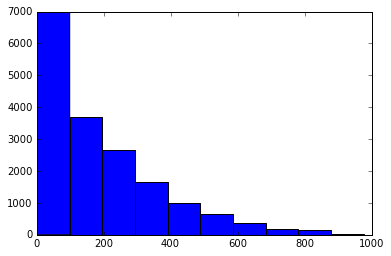

In [79]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(bike_rentals['cnt'])

### Correlations
There are over 10 different columns, or *predictors*. It will be useful to explore correlation of these individual columns with the hourly number of rentals `cnt`.

We are going to use corr function, and extract the 'cnt' column of array.

From this we see *Tempreature* and *humidity* have high correlation with `cnt`. Whereas working day and weekday have little correlation with `cnt`.

In [80]:
bike_rentals.corr()['cnt']

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

In [81]:
# Create a more useful label 'time_label' out of hour data.
def assign_label(hour):
    if hour >=0 and hour <6:
        return 4
    if hour >=6 and hour <12:
        return 1
    if hour >=12 and hour <18:
        return 2
    if hour >=18 and hour <=24:
        return 3
bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label)

### Error metric


In [82]:
# sample 80% of data for training 
train = bike_rentals.sample(frac=0.8)
train

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time_label
7879,7880,2011-11-29,4,0,11,23,0,2,1,1,0.36,0.3333,0.76,0.3881,0,53,53,3
3648,3649,2011-06-05,2,0,6,22,0,0,0,1,0.64,0.5909,0.78,0.2239,36,94,130,3
14857,14858,2012-09-16,3,1,9,6,0,0,0,1,0.50,0.4848,0.72,0.0000,9,26,35,1
9513,9514,2012-02-06,1,1,2,8,0,1,1,1,0.16,0.1818,0.86,0.1343,10,434,444,1
2864,2865,2011-05-04,2,0,5,6,0,3,1,3,0.34,0.3030,0.93,0.3881,0,21,21,1
14004,14005,2012-08-11,3,1,8,17,0,6,0,3,0.74,0.6970,0.66,0.3582,220,292,512,2
9517,9518,2012-02-06,1,1,2,12,0,1,1,1,0.32,0.3182,0.61,0.1642,19,131,150,2
518,519,2011-01-23,1,0,1,17,0,0,0,1,0.14,0.1061,0.26,0.3881,5,50,55,2
14816,14817,2012-09-14,3,1,9,13,0,5,1,2,0.70,0.6515,0.54,0.1940,107,301,408,2
12590,12591,2012-06-13,2,1,6,19,0,3,1,1,0.70,0.6364,0.34,0.3881,123,548,671,3


In [83]:
# use remaining rows for test 
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]
test

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time_label
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32,4
13,14,2011-01-01,1,0,1,13,0,6,0,2,0.46,0.4545,0.72,0.2985,47,47,94,2
19,20,2011-01-01,1,0,1,19,0,6,0,3,0.42,0.4242,0.88,0.2537,6,31,37,3
28,29,2011-01-02,1,0,1,4,0,0,0,2,0.46,0.4545,0.94,0.1940,2,1,3,4
29,30,2011-01-02,1,0,1,6,0,0,0,3,0.42,0.4242,0.77,0.2985,0,2,2,1
32,33,2011-01-02,1,0,1,9,0,0,0,2,0.38,0.3939,0.76,0.2239,1,19,20,1
36,37,2011-01-02,1,0,1,13,0,0,0,2,0.36,0.3485,0.66,0.1343,11,64,75,2
39,40,2011-01-02,1,0,1,16,0,0,0,3,0.34,0.3333,0.71,0.1642,9,67,76,2
44,45,2011-01-02,1,0,1,21,0,0,0,1,0.26,0.2273,0.44,0.3284,11,20,31,3
45,46,2011-01-02,1,0,1,22,0,0,0,1,0.24,0.2121,0.44,0.2985,0,9,9,3


In [84]:
# all columns
columns = list(train.columns)
# remove columns
columns.remove('cnt')
columns.remove('casual')
columns.remove('dteday')
columns.remove('registered')

### Linear Regression model
From the mean squared error of 18,629 on predicting the `cnt` values, it seems Linear regression model has not performed well on this type of data set. Let us explore how much it will be with  decision tree.

In [85]:
from sklearn.linear_model import LinearRegression

model_r = LinearRegression()
model_r.fit(train[columns], train['cnt'])
predictions_r = model_r.predict(test[columns])
# mean squared error of Linear regression
mse_r = np.mean((predictions_r - test['cnt'])**2)
mse_r

18629.981425871058

### Decision Tree
On this data, as comes out below, the error from decision tree algorithm `2791` is *6 times* better than Linear regression `18629`.

In [89]:
from sklearn.tree import DecisionTreeRegressor

model_tree = DecisionTreeRegressor(min_samples_leaf=2)
model_tree.fit(train[columns], train['cnt'])
predictions_tree = model_tree.predict(test[columns])
# mean squared error of Tree
mse_tree = np.mean((predictions_tree - test['cnt'])**2)
mse_tree

2791.5972621787496

There is a minor further improvement by change of sample leaf

In [87]:
model_tree = DecisionTreeRegressor(min_samples_leaf=5)

model_tree.fit(train[columns], train['cnt'])
predictions_tree = model_tree.predict(test[columns])
# Means squared error
mse_tree = np.mean((predictions_tree - test['cnt'])**2)
mse_tree

2628.003389472889

### Random Forest
After seeing the application of decision tree, we are now applying the *ensemble* method, the Random Forest Regressor.

The mse has fallen further by **`23%`** from decision tree. This is great result.

In [88]:
from sklearn.ensemble import RandomForestRegressor

model_forest = RandomForestRegressor(min_samples_leaf=5)
model_forest.fit(train[columns], train['cnt'])
predictions_forest = model_forest.predict(test[columns])
# Mean squared error for Random Forest
mse_forest = np.mean((predictions_forest - test['cnt'])**2)
mse_forest


2064.7335160158877

## Summary
Random Forest have worked brilliantly on this dataset, in predicting the continously varying value of `cnt`, especially when compared to linear regression. 

MSE of `2064` in random forest is far better than `18629` in linear regression model. *Hence predictive power of decision trees/random forest is better suited to this problem of predicting bike rentals, than linear regression, with **9** times less MSE.*